# Module 3: Infer Language Models

* DS 6001
* Raf Alvarado

We now create a series of langage models and evaluate them.

# Configure

In [1]:
OHCO = ['book_id', 'chap_num', 'para_num', 'sent_num', 'token_num']
text_file1 = '../MOD02--TextModels/austen-persuasion.csv'
text_file2 = '../MOD02--TextModels/austen-sense.csv'

# Set Up

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

# Import and combine texts

In [3]:
text1 = pd.read_csv(text_file1, index_col=OHCO[1:])
text2 = pd.read_csv(text_file2, index_col=OHCO[1:])

In [4]:
text1['book_id'] = 1
text2['book_id'] = 2

In [160]:
corpus = pd.concat([text1, text2])
corpus = corpus.reset_index().set_index(OHCO).fillna(' ')
# corpus = corpus[~corpus.token_str.isna()]

In [167]:
corpus.sample(5)

token_str
book_id chap_num para_num sent_num token_num              
1       1        10       8        18                 with
2       31       28       27       2                     I
1       22       7        1        7                body's
2       33       52       3        18         good-natured
        1        10       1        11              despise

# Create a vocabulary

In [168]:
corpus['term_str'] =  corpus['token_str'].str.lower().str.replace(r'[\W_]', '')
corpus = corpus[~corpus.term_str.str.match(r'^\s*$')]

In [171]:
vocab = corpus['term_str'].value_counts()\
    .to_frame()\
    .reset_index()\
    .rename(columns={'term_str':'n', 'index':'term_str'})\
    .sort_values('term_str')
vocab.index.name = 'term_id'

In [573]:
vocab.head()

,term_str,n,p,log_p
term_id,,,,
3659,1,3,0.000015,-16.040311
6747,15,1,0.000005,-17.625274
8163,16,1,0.000005,-17.625274
6062,1760,1,0.000005,-17.625274
8316,1784,1,0.000005,-17.625274


# Create Unigram Model

In [173]:
n_tokens = vocab.n.sum()
vocab['p'] = vocab['n'] / n_tokens
vocab['log_p'] = np.log2(vocab['p'])

In [174]:
vocab.sort_values('p', ascending=False).head(10)

,term_str,n,p,log_p
term_id,,,,
0,the,7421,0.036705,-4.767876
1,to,6872,0.033990,-4.878759
2,and,6227,0.030799,-5.020952
3,of,6136,0.030349,-5.042191
4,her,3731,0.018454,-5.759927
5,a,3636,0.017984,-5.797137
6,in,3316,0.016401,-5.930045
7,was,3182,0.015739,-5.989556
8,i,3074,0.015204,-6.039372


In [175]:
smooth = vocab['p'].min()
def predict_sentence(sent_str):
    tokens = pd.DataFrame(sent_str.lower().split(), columns=['term_str'])
    tokens = tokens.merge(vocab, on='term_str', how='left')
    tokens.loc[tokens['p'].isna(), ['p', 'log_p']] = [smooth, np.log2(smooth)]
    p = tokens['p'].product()
    log_p = tokens['log_p'].sum()
    print('-' * 80)
    print("p('{}') = {}; log2: {}".format(sent_str, p, log_p))
    print('-' * 80)
    print(tokens)
    print('-' * 80)

In [177]:
predict_sentence('I love you')
predict_sentence('I love cars')
predict_sentence("I want to")
predict_sentence("anne said to")
predict_sentence("said to her")

--------------------------------------------------------------------------------
p('I love you') = 7.803004943160364e-08; log2: -23.611394945157244
--------------------------------------------------------------------------------
  term_str     n         p      log_p
0        i  3074  0.015204  -6.039372
1     love   117  0.000579 -10.754909
2      you  1793  0.008868  -6.817114
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
p('I love cars') = 4.3519269063917254e-11; log2: -34.419554718025616
--------------------------------------------------------------------------------
  term_str       n         p      log_p
0        i  3074.0  0.015204  -6.039372
1     love   117.0  0.000579 -10.754909
2     cars     NaN  0.000005 -17.625274
--------------------------------------------------------------------------------
------------------------------------------------------------------

# Buld N-Gram models

This function generates models up to the length specified.

In [427]:
def get_ngrams(tokens, n=2):
    
    # Create list to store copies of tokens table
    X = []
    
    # We assume that tokens has an OHCO multiindex
    X.append(tokens['term_str'].reset_index())
        
    # Create copies of token table for each level of ngram, offset by 1, and 
    # merge with previous 
    for i in range(1, n):
        X.append(X[0].copy())
        X[i]['token_num'] = X[i]['token_num'] + i
        X[i] = X[i].merge(X[i-1], on=OHCO, how='left', sort=True).fillna('<s>')
        
    # Compress tables to unique ngrams with counts
    for i in range(0, n):
        X[i] = X[i].drop(OHCO, 1)
        cols = X[i].columns.tolist()
        X[i]['n'] = 0
        X[i] = X[i].groupby(cols).n.apply(lambda x: x.count()).to_frame()
        X[i].index.names = ['w{}'.format(j) for j in range(i+1)]
        
#     # Compute probabilities
#     for i in range(0, n):
#         N = X[i]['n'].sum()
#         X[i]['p'] = X[i]['n'] / N
#         X[i]['log_p'] = np.log2(X[i]['p'])
#         X[i]['h'] = X[i].log_p * X[i].p * -1
    
    # Return just the ngram tables
    return X

## Generate three models

Unigram, bigram, and trigram

In [509]:
m1, m2, m3 = get_ngrams(corpus, n=3)

In [512]:
m1['p'] = m1['n'] / m1['n'].sum()
m2['p'] = m2['n'] / m2['n'].sum()
m3['p'] = m3['n'] / m3['n'].sum()

In [513]:
m1.sort_values('p', ascending=False).head()

,n,p
w0,,
the,7421,0.036705
to,6872,0.033990
and,6227,0.030799
of,6136,0.030349
her,3731,0.018454


In [514]:
m2.sort_values('p', ascending=False).head()

,,n,p
w0,w1,,
of,the,856,0.004234
to,be,812,0.004016
in,the,679,0.003358
mrs,<s>,529,0.002616
it,was,490,0.002424


In [515]:
m3.sort_values('p', ascending=False).head()

,,,n,p
w0,w1,w2,,
mrs,<s>,<s>,529,0.002616
it,<s>,<s>,352,0.001741
her,<s>,<s>,236,0.001167
him,<s>,<s>,216,0.001068
mr,<s>,<s>,179,0.000885


## Compute Conditional Probabilities

$p(w_1|w_0) = p(w_0, w_1) / p(w_0)$

$p(w_2|w_0,w_1) = p(w_0, w_1, w_2) / p(w_0, w_1)$

In [516]:
m2 = m2.join(m1['p'].to_frame(), on='w0', rsuffix='_w0')
m2['p_w1gw0'] = m2.p / m2.p_w0
m2m = m2['p_w1gw0'].unstack().fillna(0)

In [517]:
m3 = m3.join(m2['p'].to_frame(), on=['w0','w1'], rsuffix='_w0w1')
m3['p_w2gw0w1'] = m3.p / m3.p_w0w1
m3m = m3['p_w2gw0w1'].unstack().fillna(0)

## Smoothing

In [518]:
alpha = .0000001
m2m = (m2m + alpha) / (alpha * m2m.shape[1])
m3m = (m3m + alpha) / (alpha * m3m.shape[1])

In [583]:
m2m.iloc[0].sum()

1103.6574043444705

## Explore

In [519]:
m2m.loc[['he','she','it','anne','wentworth'], ['is','had','was','felt','looked','said','saw']].style.background_gradient(cmap='Greens')

w1,is,had,was,felt,looked,said,saw
w0,,,,,,,
he,62.8403,161.666,133.737,5.90816,9.66783,18.2614,5.90816
she,26.5605,165.399,148.497,20.1216,5.63413,11.6706,17.707
it,103.662,25.2151,196.117,0.400349,0.400349,1.60106,0.000110266
anne,4.88994,92.9069,114.911,22.0044,2.44503,4.88994,7.33486
wentworth,17.3193,46.1847,103.915,0.000110266,5.77319,11.5463,5.77319


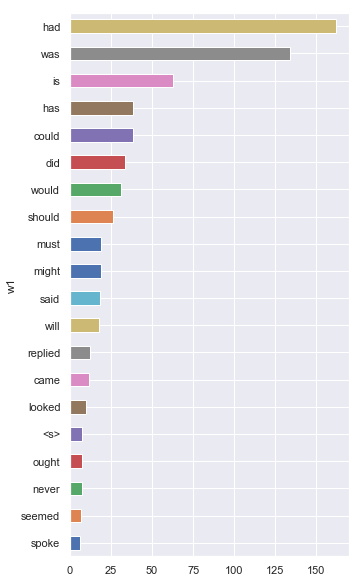

In [520]:
m2m.loc['he'].sort_values(ascending=False).head(20).sort_values().plot.barh(figsize=(5,10))

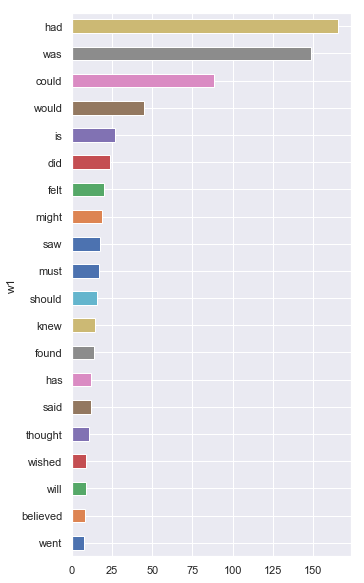

In [521]:
m2m.loc['she'].sort_values(ascending=False).head(20).sort_values().plot.barh(figsize=(5,10))

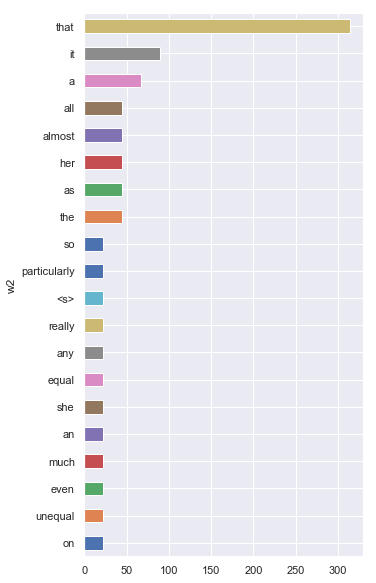

In [522]:
m3m.loc[('she','felt')].sort_values(ascending=False).head(20).sort_values().plot.barh(figsize=(5,10))

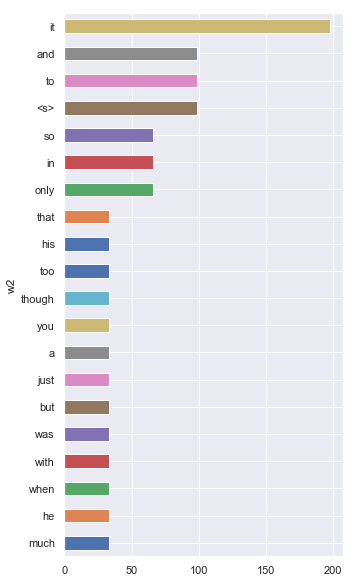

In [523]:
m3m.loc[('he','said')].sort_values(ascending=False).head(20).sort_values().plot.barh(figsize=(5,10))

# Generate Text

In [571]:
def generate_text(start_word='she', n=250):
    words = [start_word]
    for i in range(n):
        if len(words) == 1:
            w = m2m.loc[start_word]
            next_word = m2m.loc[start_word].sample(weights=w).index.values[0]
        elif len(words) > 1:
            bg = tuple(words[-2:])
            w = m3m.loc[bg]
            next_word = m3m.loc[bg].sample(weights=w).index.values[0]
            if next_word == '<s>':
                next_word = m1.sample(weights=m1.p).index[0]
        words.append(next_word)
    print(' '.join(words))

In [572]:
generate_text('she')

she could speak her happiness was from feeling thorough contentment about it his business is rights single it at the end may prove materially advantageous that occurred the while hoping for some days to make him hang back mr early shepherds the clerks piano were for a moment for speech compare too opinions ridiculous knowledge one so earnestly grateful so full of faith in the room in one person more my feelings are at present should known have to spend the next autumn to fall in love must have so greatly shaken respect ever even however then changed written anne and stopped for no other purpose than to me should i of talked himself mrs and the seclusion of kellynch to make desirable tenants as any of your sisterinlaw mrs you shirley stay family out would in all probability when she must be remember with that of barton was chiefly on one side and in its effects and at her want of more consequence to inform him of it before in her power to prevent your whole party being immediately after